In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rc('font', family = 'Malgun Gothic')
import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans,DBSCAN
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

### 워드클라우드 함수 

In [52]:
def wordcloud(grp,model):
    g1 = df_test[df_test[model] == grp].groupby('검사결과내용')['검사결과내용'].count().reset_index(name='cnt')
    
    # 결과를 딕셔너리로 변환
    g1_ditc = {}
    for idx, row  in enumerate(g1.iterrows()):
        g1_ditc[row[1]['검사결과내용']]=row[1]['cnt']

    wordcloud = WordCloud(
    font_path = 'malgun.ttf', # 한글 글씨체 설정
    background_color='white', # 배경색은 흰색으로 
    colormap='Reds', # 글씨색은 빨간색으로
    # mask=cand_mask, # 워드클라우드 모양 설정
    ).generate_from_frequencies(g1_ditc)
    
    #사이즈 설정 및 출력
    plt.figure(figsize=(5,5))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off') # 차트로 나오지 않게
    plt.title(str(grp) +'번 그룹 WordCloud')
    plt.show()

    print('---' * 30)

### 데이터 읽어오기 및 전처리

In [2]:
df = pd.read_csv('./customs_mail.csvv', low_memory=True)
df_etc = df[df['우편물검사결과코드.2'] =='99-기타'].reset_index(drop=True)

In [3]:
df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("기타농산물","농산물").str.replace("이삿짐","이사화물").str.replace("담배반송"," 담배").str.replace("담배 반송"," 담배").str.replace("농산물반송"," 농산물").str.replace("농산물 반송"," 농산물").str.replace("이사화물 반송","이사화물").str.replace("기타담배반송","담배").str.replace("과일반송","과일").str.replace("기타 담배반송","담배").str.replace("기타 이사화물반송","이사화물")
df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("기타비전자반송","비전자상거래").str.replace("기타비전자상거래물품","비전자상거래").str.replace("농산물  담배","담배").str.replace("반송농산물","농산물").str.replace("비전자 반송","비전자상거래")\
.str.replace("비전자상거래 반송","비전자상거래").str.replace("비전자상거래물품","비전자상거래").str.replace("비전자상거래반송","비전자상거래").str.replace("이사물품 반송","이사물품")
df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("기타 담배","담배").str.replace("기타담배","담배").str.replace("기타반송","기타").str.replace("농산물 담배","담배").str.replace("농산물담배","담배")\
.str.replace("반송담배","담배").str.replace("비전자반송","비전자상거래").str.replace("인근분산반입   농산물","농산물").str.replace("이사물품반송","이사물품")
df_test = df_etc.copy()

C:\Users\P-이종권\AppData\Local\Temp\ipykernel_5176\70231399.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


### 형태소 분석 및 분석결과 NULL데이터 삭제

In [4]:
okt = Okt() # 형태소 분석기 객체 생성
noun_list = []
for content in tqdm.tqdm(df_test['검사결과내용']): 
    nouns = okt.nouns(content) # 명사만 추출하기, 결과값은 명사 리스트
    noun_list.append(nouns)

100%|██████████████████████████████████████████████████████████████████████████| 14563/14563 [00:10<00:00, 1385.30it/s]


In [6]:
df_test['nouns'] = noun_list

In [8]:
df_test.head(3)

,관리년도,검사일자,검사년도,우편물검사결과코드,우편물검사결과코드.1,우편물검사결과코드.2,검사결과내용,nouns
0,2019,20191105,2019,99,기타,99-기타,농산물말린고추비전자상거래,"[농산물, 고추, 비, 전자상거래]"
1,2019,20191105,2019,99,기타,99-기타,농산물말린고추비전자상거래,"[농산물, 고추, 비, 전자상거래]"
2,2019,20191113,2019,99,기타,99-기타,농산물,[농산물]


In [9]:
noun_list[:3]

[['농산물', '고추', '비', '전자상거래'], ['농산물', '고추', '비', '전자상거래'], ['농산물']]

In [11]:
# 명사 리스트가 비어있으면 DataFrame에서 지
drop_index_list = [] # 지워버릴 index를 담는 리스트
for i, row in df_test.iterrows():
    temp_nouns = row['nouns']
    if len(temp_nouns) == 0: # 만약 명사리스트가 비어 있다면
        drop_index_list.append(i) # 지울 index 추가
        
df_test = df_test.drop(drop_index_list) # 해당 index를 지우기

# index를 지우면 순회시 index 값이 중간중간 비기 때문에 index를 다시 지정
df_test.index = range(len(df_test))

### TFIDF방식으로 문장벡터화

In [15]:
# 단어를 문장으로 합침
[" ".join(noun) for noun in df_test['nouns'][1000:1002]]

['농산물', '농산물']

In [20]:

# 문서를 명사 집합으로 보고 문서 리스트로 치환 (tfidfVectorizer 인풋 형태를 맞추기 위해)
text = [" ".join(noun) for noun in df_test['nouns']]

# min-df 특정단어가 문서에 나타는 빈도수 (예 : 4개 문장에 home이 4번 등장하나 단어를 포함하는 문장이 3개이면 df=3임)
# ngram_range : 1로 설정하면 단어별 벡터를 만들고 5로 설정하면 한 단어부터 5개 단어까지 묶어서 개별 벡터 생성
tfidf_vectorizer = TfidfVectorizer(min_df=2,ngram_range=(1,5))
# 문장을 하나로 벡터화 학습
tfidf_vectorizer.fit(text)

# tfidf_vectorizer.vocabulary_ # 벡터라이저가 학습한 단어사전 출력
# 행별 학습한 벡터를 배열로 반환
vector = tfidf_vectorizer.transform(text).toarray()

In [21]:
# 행의 수, 벡터차원
vector.shape

(14547, 423)

In [23]:
vector[:][1000]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Kmeans로 비지도학습

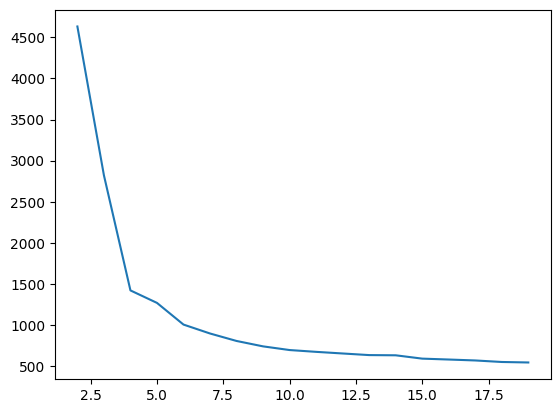

In [24]:
# 그룹수 튜닝
itr = []
for i in range(2,20):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(vector)
    itr.append(km.inertia_)
    
plt.plot(range(2,20), itr)
plt.show()   

In [30]:
# Kmeans : 클러스터 중심점과 가까운 데이터를 클러스터

# 첫번째 꺽임점 4를 우선 고려 다음 꺽임점 6를 두번째로 고려

model = KMeans(n_clusters=4, random_state=42, init='k-means++',max_iter=100, n_init=1)
model.fit(vector)

KMeans(max_iter=100, n_clusters=4, n_init=1, random_state=42)

In [31]:
# 그룹핑 결과를 데이터프레임에 적용
df_test['kmeans'] = model.labels_

In [33]:
df_test['kmeans'].value_counts()

0    7722
1    4004
3    1633
2    1188
Name: kmeans, dtype: int64

In [41]:
np.unique(model.labels_)

array([0, 1, 2, 3])

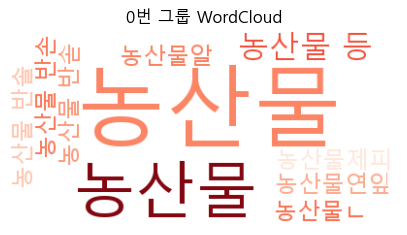

------------------------------------------------------------------------------------------


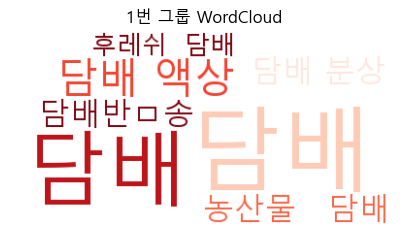

------------------------------------------------------------------------------------------


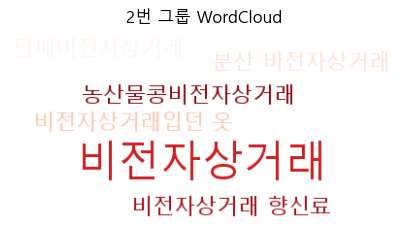

------------------------------------------------------------------------------------------


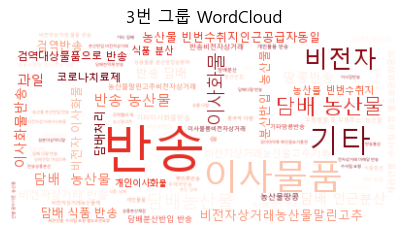

------------------------------------------------------------------------------------------


In [106]:
# 그룹별 워드클라우드 시각화
for i in range(df_test['kmeans'].max()+1):
    wordcloud(i,'kmeans')

### DBSCAN방식으로 비지도학습

In [180]:
# DBSCAN : 인접한 데이터를 클러스터링

vector = np.array(vector) # Normalizer를 이용해 변환된 벡터
# eps 그룹핑할 최대 반경거리
# min_samples 그룹핑한 반경안의 최소 샘플 갯수
model = DBSCAN(eps=0.4,min_samples=40)

# 거리 계산 식으로는 Cosine distance를 이용
model.fit(vector)
result = model.fit_predict(vector)

In [181]:
df_test['dbscan'] = result

In [100]:
result.data

In [121]:
df_test.head(10)

,관리년도,검사일자,검사년도,우편물검사결과코드,우편물검사결과코드.1,우편물검사결과코드.2,검사결과내용,nouns,kmeans,dbscan
0,2019,20191105,2019,99,기타,99-기타,농산물말린고추비전자상거래,"[농산물, 고추, 비, 전자상거래]",3,-1
1,2019,20191105,2019,99,기타,99-기타,농산물말린고추비전자상거래,"[농산물, 고추, 비, 전자상거래]",3,-1
2,2019,20191113,2019,99,기타,99-기타,농산물,[농산물],0,0
3,2019,20191125,2019,99,기타,99-기타,이사화물,[화물],3,1
4,2019,20191219,2019,99,기타,99-기타,과일,[과일],3,2
5,2019,20191104,2019,99,기타,99-기타,개장검사 결과 이사물품,"[개장, 검사, 결과, 이사, 물품]",3,-1
6,2019,20191219,2019,99,기타,99-기타,과일,[과일],3,2
7,2019,20191219,2019,99,기타,99-기타,과일,[과일],3,2
8,2019,20191223,2019,99,기타,99-기타,비전자상거래입던 옷 신발,"[비, 전자상거래, 옷, 신발]",3,-1
9,2019,20191125,2019,99,기타,99-기타,매실 반송,"[매실, 반송]",3,3


In [182]:
np.unique(df_test['dbscan'])

array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64)

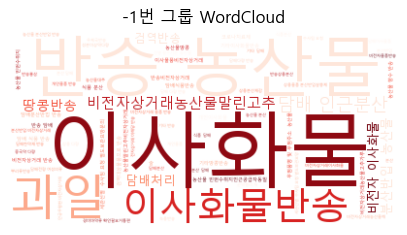

------------------------------------------------------------------------------------------


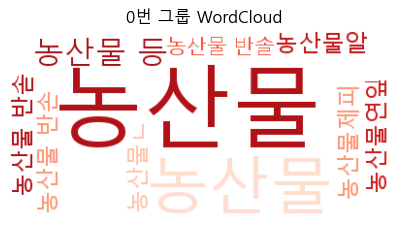

------------------------------------------------------------------------------------------


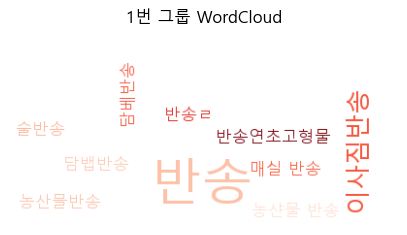

------------------------------------------------------------------------------------------


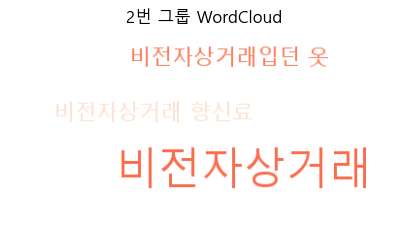

------------------------------------------------------------------------------------------


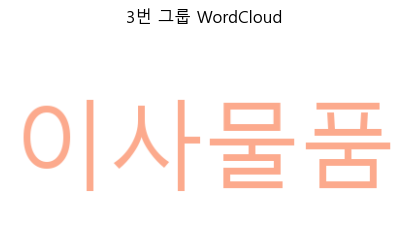

------------------------------------------------------------------------------------------


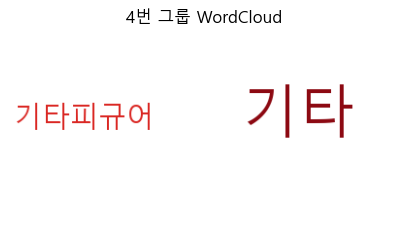

------------------------------------------------------------------------------------------


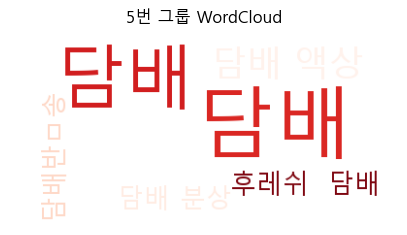

------------------------------------------------------------------------------------------


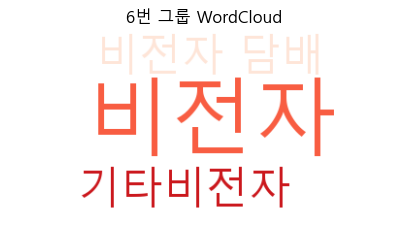

------------------------------------------------------------------------------------------


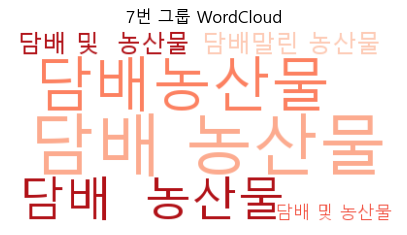

------------------------------------------------------------------------------------------


In [183]:
# 그룹별 워드클라우드 시각화
for i in range(-1,df_test['dbscan'].max()+1):
    wordcloud(i,'dbscan')

In [112]:
dbscan = df_test.groupby(['kmeans','검사결과내용'])['검사결과내용'].count().sort_values(ascending=False).reset_index(name='ditc_count')

In [155]:
g1 = df_test[df_test['kmeans'] ==2].groupby('검사결과내용')['검사결과내용'].count().reset_index(name='cnt')